# Test Field

In [1]:
# utility 
import numpy as np
import matplotlib.pyplot as plt

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper


True


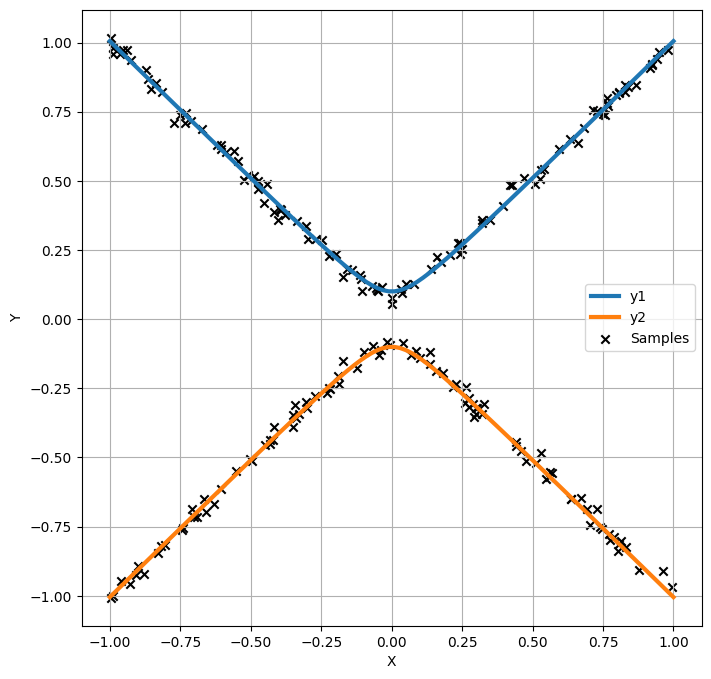

In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola

# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 200
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
from torch.utils.data import DataLoader, TensorDataset

# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Discriminator modified to output raw logits instead of sigmoid
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            # Removed sigmoid to get raw logits
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss using log probabilities as per the formula"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)
    
    # Compute log probabilities
    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)  # Add small epsilon to prevent log(0)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)
    
    # Average over batch
    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))
    
    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(torch.sigmoid(d_fake) + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            position = batch_x
            angles = batch_y
            
            # Step 1: Update discriminator
            for _ in range(30):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(position.size(0), generator.latent_size)
                
                # Generate fake samples
                fake_angles = generator(z, position)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, angles, fake_angles.detach(), position
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(position.size(0), generator.latent_size)
            fake_angles = generator(z, position)
            g_loss = compute_generator_loss(discriminator, fake_angles, position)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 0
hidden_size = 64
output_size = 1
condition_size = 1
num_epochs = 100
batch_size = 32
learning_rate_d = 0.0002
learning_rate_g = 0.00005

# Prepare the dataset and dataloader
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/100], Discriminator Loss: 0.9652, Generator Loss: 0.9312
Epoch [2/100], Discriminator Loss: 0.6832, Generator Loss: 1.2620
Epoch [3/100], Discriminator Loss: 0.5695, Generator Loss: 1.5767
Epoch [4/100], Discriminator Loss: 0.4418, Generator Loss: 1.9156
Epoch [5/100], Discriminator Loss: 0.1374, Generator Loss: 3.4078
Epoch [6/100], Discriminator Loss: 0.0318, Generator Loss: 4.4601
Epoch [7/100], Discriminator Loss: 0.1372, Generator Loss: 3.1810
Epoch [8/100], Discriminator Loss: 0.0646, Generator Loss: 4.7580
Epoch [9/100], Discriminator Loss: 0.0134, Generator Loss: 5.3217
Epoch [10/100], Discriminator Loss: 0.0367, Generator Loss: 4.9699
Epoch [11/100], Discriminator Loss: 0.0132, Generator Loss: 5.9165
Epoch [12/100], Discriminator Loss: 0.0462, Generator Loss: 5.6072
Epoch [13/100], Discriminator Loss: 0.2737, Generator Loss: 5.6403
Epoch [14/100], Discriminator Loss: 0.0690, Generator Loss: 4.9176
Epoch [15/100], Discriminator Loss: 0.1650, Generator Loss: 4.9696
Epoc

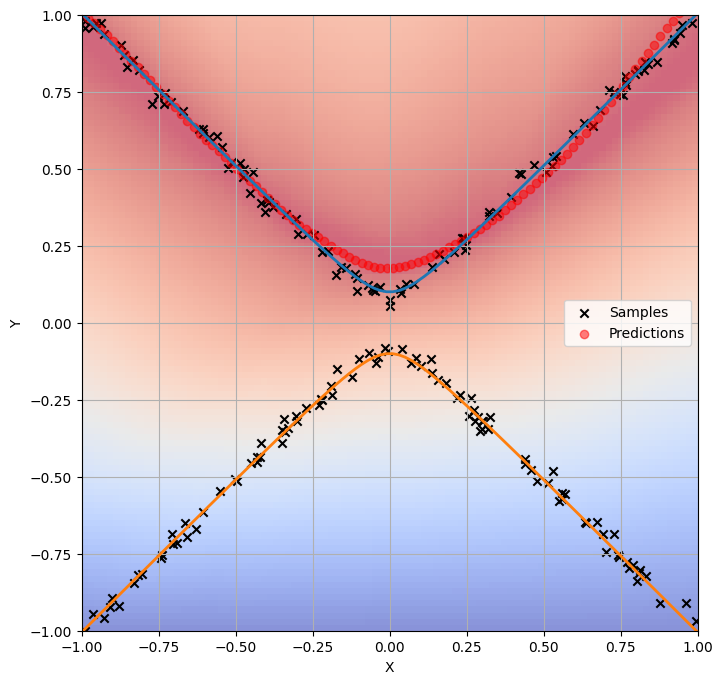

In [7]:
# Visualize the discriminator output heatmap and the predictions
# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions = generator(z, query_points_tensor).detach().numpy()

# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Compute discriminator output for each grid point
discriminator_outputs = []
for point in grid_points:
    x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
    y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
    output = discriminator(y_plot, x_plot).detach()
    # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
    discriminator_outputs.append(output.item())

# Reshape the outputs to match the grid
discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
# Normalize every column of the heatmap
discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

# As energy, take minus of the discriminator output
discriminator_outputs = -discriminator_outputs

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)


# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val,  linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: -0.0000
Epoch [2/100], Generator Loss: -0.0000
Epoch [3/100], Generator Loss: -0.0000
Epoch [4/100], Generator Loss: -0.0000
Epoch [5/100], Generator Loss: -0.0000
Epoch [6/100], Generator Loss: -0.0000
Epoch [7/100], Generator Loss: -0.0000
Epoch [8/100], Generator Loss: -0.0000
Epoch [9/100], Generator Loss: -0.0000
Epoch [10/100], Generator Loss: -0.0000
Epoch [11/100], Generator Loss: -0.0000
Epoch [12/100], Generator Loss: -0.0000
Epoch [13/100], Generator Loss: -0.0000
Epoch [14/100], Generator Loss: -0.0000
Epoch [15/100], Generator Loss: -0.0000
Epoch [16/100], Generator Loss: -0.0000
Epoch [17/100], Generator Loss: -0.0000
Epoch [18/100], Generator Loss: -0.0000
Epoch [19/100], Generator Loss: -0.0000
Epoch [20/100], Generator Loss: -0.0000
Epoch [21/100], Generator Loss: -0.0000
Epoch [22/100], Generator Loss: -0.0000
Epoch [23/100], Generator Loss: -0.0000
Epoch [24/100], Generator Loss: -0.0000
Epoch [25/100], Generator Loss: -0.0000
Epoch [26

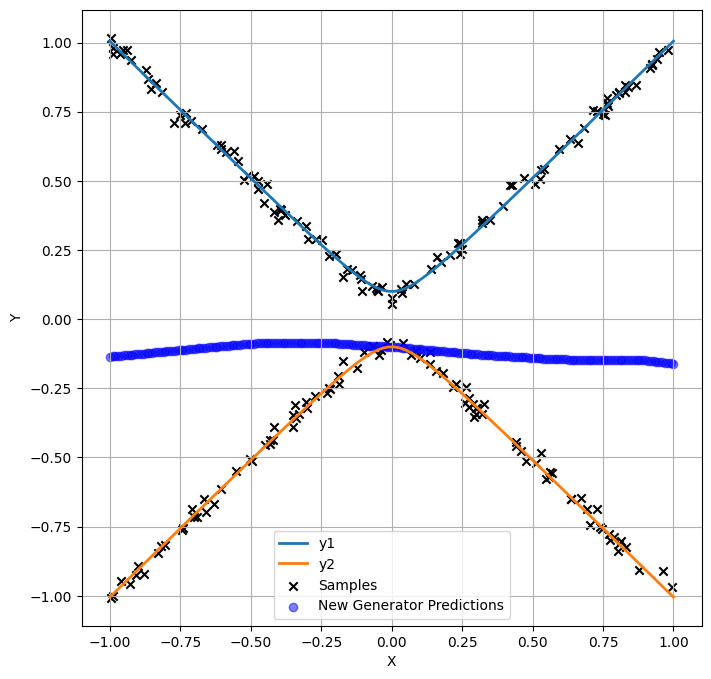

In [9]:
# Fix the discriminator and train a new generator
# Fix the discriminator parameters
for param in discriminator.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        position = batch_x
        angles = batch_y
        
        # Draw noise samples
        z = torch.randn(position.size(0), new_generator.latent_size)
        
        # Generate fake samples
        fake_angles = new_generator(z, position)
        
        # Compute generator loss
        g_loss = compute_generator_loss(discriminator, fake_angles, position)
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")
    
    
# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions_new = new_generator(z, query_points_tensor).detach().numpy()

# Plot the function, samples, and predictions from new_generator
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Training loop
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            positions = batch_x.to(device)
            angles = batch_y.to(device)
            
            counter_samples = generate_counter_samples(y_min, y_max, positions.size(0), neg_count, device)
            
            # Compute loss
            loss = criterion(model, positions, angles, counter_samples)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
# Hyperparameters
input_size = 1  # x, y positions
action_size = 1  # joint angles
hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 256
learning_rate = 0.001

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint angle limits (radians)
y_max = torch.tensor([1])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Load dataset
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train the model
train(energy_model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Loss: 5.5460, LR: 0.001000
Epoch [2/100], Loss: 5.5365, LR: 0.001000
Epoch [3/100], Loss: 5.5286, LR: 0.001000
Epoch [4/100], Loss: 5.5219, LR: 0.001000
Epoch [5/100], Loss: 5.5158, LR: 0.001000
Epoch [6/100], Loss: 5.5082, LR: 0.001000
Epoch [7/100], Loss: 5.4941, LR: 0.001000
Epoch [8/100], Loss: 5.4903, LR: 0.001000
Epoch [9/100], Loss: 5.4712, LR: 0.001000
Epoch [10/100], Loss: 5.4633, LR: 0.001000
Epoch [11/100], Loss: 5.4436, LR: 0.001000
Epoch [12/100], Loss: 5.4288, LR: 0.001000
Epoch [13/100], Loss: 5.4025, LR: 0.001000
Epoch [14/100], Loss: 5.3845, LR: 0.001000
Epoch [15/100], Loss: 5.3606, LR: 0.001000
Epoch [16/100], Loss: 5.3357, LR: 0.001000
Epoch [17/100], Loss: 5.3004, LR: 0.001000
Epoch [18/100], Loss: 5.2657, LR: 0.001000
Epoch [19/100], Loss: 5.2405, LR: 0.001000
Epoch [20/100], Loss: 5.2243, LR: 0.000500
Epoch [21/100], Loss: 5.2141, LR: 0.000500
Epoch [22/100], Loss: 5.1768, LR: 0.000500
Epoch [23/100], Loss: 5.1680, LR: 0.000500
Epoch [24/100], Loss

In [12]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Derivative-free optimizer for inference
def ebm_infer(energy_model, target_position, y_min, y_max, samples=16384, iterations=4, sigma_init=0.33, scale=0.5):
    """
    Find angles that minimize energy for a given target position.

    Args:
        energy_model: Trained energy-based model.
        target_position: Target position (Cartesian coordinates), shape: (1, input_dim).
        y_min: Minimum values for joint angles (tensor).
        y_max: Maximum values for joint angles (tensor).
        samples: Number of random samples for initial exploration.
        iterations: Number of optimization iterations.
        sigma_init: Initial noise level for exploration.
        scale: Scaling factor for noise reduction.

    Returns:
        Optimal joint angles minimizing the energy.
    """
    device = target_position.device
    target_position = target_position.repeat(samples, 1)  # Repeat for batch inference
    sigma = sigma_init

    # Initialize random joint angle samples
    angles = torch.rand((samples, y_min.size(-1)), device=device) * (y_max - y_min) + y_min

    for _ in range(iterations):
        # Compute energies for current samples
        # If energy_model is type EnergyModel, you can use energy_model(target_position, angles)
        # elif energy_model is typr Discriminator, you can use -energy_model(angles, target_position)
        if isinstance(energy_model, EnergyModel):
            energies = energy_model(target_position, angles)
        elif isinstance(energy_model, Discriminator):
            energies = -energy_model(angles, target_position)
        else:
            raise ValueError("Invalid energy model type.")

        # Softmax over negative energies for sampling probabilities
        probabilities = torch.softmax(-energies, dim=0)

        # Resample based on probabilities
        indices = torch.multinomial(probabilities, num_samples=samples, replacement=True)
        angles = angles[indices]

        # Add noise for exploration
        angles += torch.randn_like(angles) * sigma
        angles = torch.clamp(angles, y_min, y_max)  # Clamp to valid joint angle bounds

        # Reduce noise scale
        sigma *= scale

    # Return the angles corresponding to the minimum energy
    best_idx = torch.argmin(energies)
    return angles[best_idx].unsqueeze(0)  # Shape: (1, action_dim)


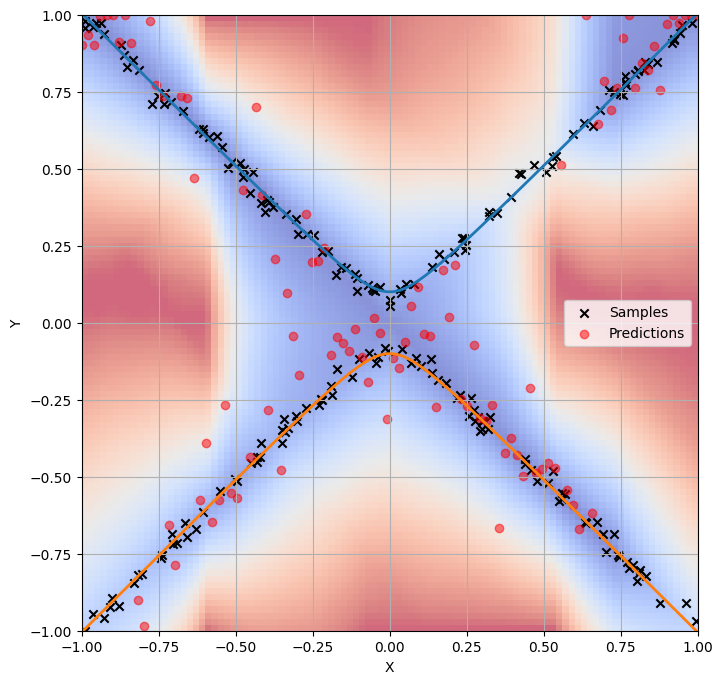

In [13]:

# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)

predictions = []
for point in query_points:
    query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
    prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
    predictions.append(prediction.item())


# Visualize the energy model output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: 1.1360
Epoch [2/100], Generator Loss: 2.0829
Epoch [3/100], Generator Loss: 0.9467
Epoch [4/100], Generator Loss: 0.6740
Epoch [5/100], Generator Loss: 1.7014
Epoch [6/100], Generator Loss: 0.9187
Epoch [7/100], Generator Loss: 1.3873
Epoch [8/100], Generator Loss: 1.1124
Epoch [9/100], Generator Loss: 1.6057
Epoch [10/100], Generator Loss: 1.3457
Epoch [11/100], Generator Loss: 1.3770
Epoch [12/100], Generator Loss: 1.3931
Epoch [13/100], Generator Loss: 1.5804
Epoch [14/100], Generator Loss: 1.2126
Epoch [15/100], Generator Loss: 1.1840
Epoch [16/100], Generator Loss: 1.0964
Epoch [17/100], Generator Loss: 1.2126
Epoch [18/100], Generator Loss: 1.5810
Epoch [19/100], Generator Loss: 0.9457
Epoch [20/100], Generator Loss: 1.3405
Epoch [21/100], Generator Loss: 0.9869
Epoch [22/100], Generator Loss: 0.6141
Epoch [23/100], Generator Loss: 0.9079
Epoch [24/100], Generator Loss: 0.6420
Epoch [25/100], Generator Loss: 0.8656
Epoch [26/100], Generator Loss: 0.

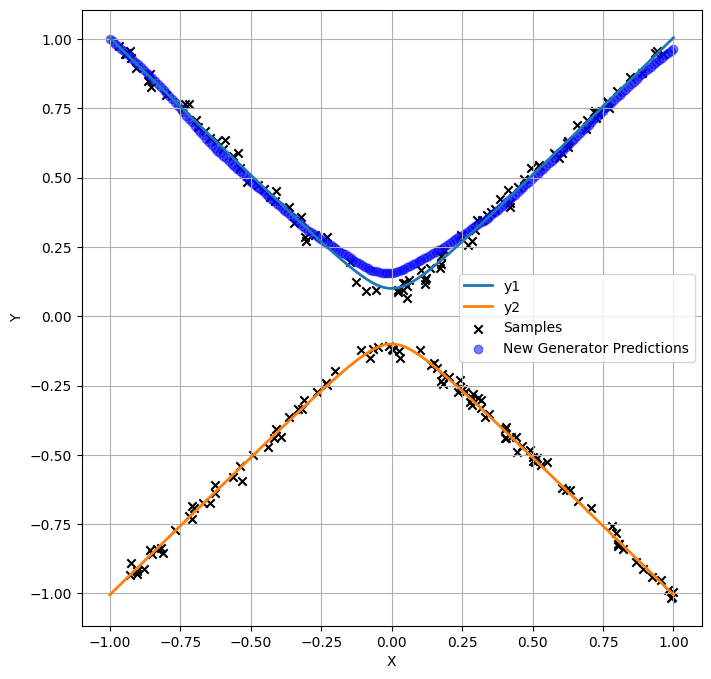

In [35]:
# Fixed the energy model and train a new generator
# Fix the energy model parameters
for param in energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        position = batch_x.to(device)
        angles = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(position.size(0), new_generator.latent_size).to(device)
        
        # Generate fake samples
        fake_angles = new_generator(z, position)
        
        # Compute generator loss
        g_loss = energy_model(position, fake_angles).mean()
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")

# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_new = new_generator(z, query_points_tensor).detach().cpu().numpy()

# Plot the function, samples, and predictions from new_generator
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()


---